# Data processing

## Load data

In [218]:
from utils import *

import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sb
from copy import deepcopy

%matplotlib inline

account_df = read_to_df("account.csv")
card_test_df = read_to_df("card_test.csv")
card_train_df = read_to_df("card_train.csv")
client_df = read_to_df("client.csv")
disp_df = read_to_df("disp.csv")
district_df = read_to_df("district.csv")
loan_test_df = read_to_df("loan_test.csv")
loan_train_df = read_to_df("loan_train.csv")
trans_test_df = read_to_df("trans_test.csv")
trans_train_df = read_to_df("trans_train.csv")

<ipython-input-218-71199e3142ca>:19: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  trans_train_df = read_to_df("trans_train.csv")


## Process data

### Process account data

In [219]:
avg_transactions_per_week = 3
avg_weeks_per_month = (365.25 / 7 / 12)

account_df['frequency'] = account_df['frequency'].apply(lambda x: 1 if x == 'monthly issuance' else avg_weeks_per_month if x == 'weekly issuance' else (365.25 / 7 / 12) * avg_transactions_per_week)
account_df["date"] = account_df["date"].apply(lambda x: read_date(x))
account_df.rename(columns={"date": "creation_date", "frequency": "issuance_frequency_per_month"}, inplace=True)

account_df.head()

,account_id,district_id,issuance_frequency_per_month,creation_date
0,576,55,1.0,1993-01-01
1,3818,74,1.0,1993-01-01
2,704,55,1.0,1993-01-01
3,2378,16,1.0,1993-01-01
4,2632,24,1.0,1993-01-02


### Process client data

In [220]:
client_df["sex"] = client_df["birth_number"].apply(lambda x: 0 if int(str(x)[2:4]) > 50 else 1)
client_df["age"] = client_df["birth_number"].apply(lambda x: calculate_age(read_date(x)))

client_df.drop("birth_number", inplace=True, axis=1)

client_df.head()

,client_id,district_id,sex,age
0,1,18,0,28
1,2,1,1,53
2,3,1,0,58
3,4,5,1,42
4,5,5,0,38


### Process disposition data

In [221]:
disp_df.rename(columns={"type": "is_owner"}, inplace=True)
disp_df["is_owner"].replace({"OWNER": True, "DISPONENT": False}, inplace=True)

# Count number clients per account
client_count_df = disp_df.groupby("account_id", as_index=False, group_keys=False).agg(client_count=("is_owner", "count"))

disp_df = disp_df.merge(client_count_df, on="account_id")
disp_df = disp_df[disp_df["is_owner"] == True] 
disp_df.drop("is_owner", axis=1, inplace=True)

disp_df.head()

,disp_id,client_id,account_id,client_count
0,1,1,1,1
1,2,2,2,2
3,4,4,3,2
5,6,6,4,1
6,7,7,5,1


### Process transaction data

In [222]:
dataframes = [trans_train_df, trans_test_df]

for i in range(len(dataframes)):
    dataframes[i]["operation"].replace(
        {
            "credit in cash": 1,
            "collection from another bank": 2,
            "withdrawal in cash": 3,
            "remittance to another bank": 4,
            "credit card withdrawal": 5,
            "interest credited": 6
        },
        inplace=True
    )

    # Convert "withdrawal in cash" to "withdrawal" in type column
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal in cash", "type"] = "withdrawal"

    # Withdrawal amounts should be negative
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal", "amount"] *= -1

    dataframes[i]["date"] = dataframes[i]["date"].apply(lambda x: read_date(x))
    dataframes[i].rename(columns={"date": "transaction_date"}, inplace=True)

    dataframes[i].drop(["k_symbol", "bank", "account"], axis=1, inplace=True)

trans_train_df, trans_test_df = dataframes

trans_train_df.head()

,trans_id,account_id,transaction_date,type,operation,amount,balance
0,1548749,5270,1993-01-13,credit,1.0,800.0,800.0
1,1548750,5270,1993-01-14,credit,2.0,44749.0,45549.0
2,3393738,11265,1993-01-14,credit,1.0,1000.0,1000.0
3,3122924,10364,1993-01-17,credit,1.0,1100.0,1100.0
4,1121963,3834,1993-01-19,credit,1.0,700.0,700.0


### Process card data

In [223]:
dataframes = [card_train_df, card_test_df]

for i in range(len(dataframes)):
    dataframes[i]["type"].replace({"classic": 1, "junior": 2, "gold": 3}, inplace=True)
    dataframes[i]["issued"] = dataframes[i]["issued"].apply(lambda x: read_date(x))

card_train_df, card_test_df = dataframes

card_train_df.head()

,card_id,disp_id,type,issued
0,1005,9285,1,1993-11-07
1,104,588,1,1994-01-19
2,747,4915,1,1994-02-05
3,70,439,1,1994-02-08
4,577,3687,1,1994-02-15


### Process demographic data

In [224]:

district_df.replace("?", np.NaN, inplace=True)

district_df["unemploymant rate '95"].fillna(district_df["unemploymant rate '95"].median(), inplace=True)
district_df["no. of commited crimes '95"].fillna(district_df["no. of commited crimes '95"].median(), inplace=True)

district_df["unemploymant rate '95"] = pd.to_numeric(district_df["unemploymant rate '95"])
district_df["no. of commited crimes '95"] = pd.to_numeric(district_df["no. of commited crimes '95"])

district_df["criminality_growth"] = (district_df["no. of commited crimes '96"] - district_df["no. of commited crimes '95"]) / district_df["no. of inhabitants"]
district_df["unemployment_growth"] = (district_df["unemploymant rate '96"] - district_df["unemploymant rate '95"])
district_df["ratio_entrepeneurs"] = district_df["no. of enterpreneurs per 1000 inhabitants"] / 1000

district_df.drop([
    "unemploymant rate '95",
    "unemploymant rate '96",
    "no. of commited crimes '95",
    "no. of commited crimes '96",
    "no. of enterpreneurs per 1000 inhabitants"
], axis=1, inplace=True)

### Process loan data

In [225]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    loan_dfs[i]["date"] = loan_dfs[i]["date"].apply(lambda x: read_date(x))
    loan_dfs[i].rename(columns={"date": "loan_date", "amount": "loan_amount"}, inplace=True)

## Generate feature from transaction data

In [226]:
# transactions = (trans_train_df, trans_test_df)
# account_features = [1, 2]

# for i in range(len(transactions)):
#     # Sorting transactions by date to figure out the most recent balance
#     account_features[i] = transactions[i].sort_values(by="date", axis=0, ascending=False)
#     account_features[i].drop_duplicates(subset='account_id', keep='first', inplace=True)

#     account_features[i].drop(account_features[i].columns.difference(['account_id', 'balance']), axis=1, inplace=True)
#     account_features[i].rename(columns={'balance': 'final_amount'}, inplace=True)

# account_features[0]

## Merge data

In [227]:
loan_dfs = [loan_train_df, loan_test_df]
trans_dfs = (trans_train_df, trans_test_df)
cards_dfs = (card_train_df, card_test_df)

for i in range(len(loan_dfs)):
    # Merge with dispositions
    loan_dfs[i] = loan_dfs[i].merge(disp_df, on="account_id", how="left")

    # Merge with accounts
    loan_dfs[i] = loan_dfs[i].merge(account_df, on="account_id")

    # Merge with clients
    loan_dfs[i] = loan_dfs[i].merge(client_df, on="client_id", suffixes=["_account", "_client"])

    # Merge with districts
    loan_dfs[i] = loan_dfs[i].merge(district_df, left_on="district_id_client", right_on="code")

    # Merge with cards
    loan_dfs[i] = loan_dfs[i].merge(cards_dfs[i], on="disp_id", how="left")

    # Merge with transactions
    loan_dfs[i] = loan_dfs[i].merge(trans_dfs[i], on="account_id", suffixes=["_card", "_transaction"])

loan_train_df, loan_test_df = loan_dfs

## Encode district name

In [228]:
loan_train_df["status"] = loan_train_df["status"].apply(lambda x: True if (x == 1) else False)
columns = ["region"]
woe_encoder = ce.WOEEncoder(cols=columns).fit(loan_train_df[columns], loan_train_df["status"])
woe_encoded_train = woe_encoder.transform(loan_train_df[columns]).add_suffix('_woe')
loan_train_df = loan_train_df.join(woe_encoded_train)
loan_train_df["status"] = loan_train_df["status"].apply(lambda x: 1 if (x == True) else -1)

loan_test_df["status"] = loan_test_df["status"].apply(lambda x: True if (x == 1) else False)
woe_encoded_test = woe_encoder.transform(loan_test_df[columns]).add_suffix('_woe')
loan_test_df = loan_test_df.join(woe_encoded_test)
loan_test_df["status"] = loan_test_df["status"].apply(lambda x: 1 if (x == True) else -1)


## Dropping features

- All cards can be dropped as there are only 11 out of the total 328 loans making it very hard or impossible to fill in missing values.
- IDs are no longer needed

In [229]:
loan_dfs = [loan_train_df, loan_test_df]

for i in range(len(loan_dfs)):
    loan_dfs[i].drop(["card_id", "type_card", "issued"], axis=1, inplace=True)
    loan_dfs[i].drop(["disp_id", "account_id", "client_id"], axis=1, inplace=True)
    loan_dfs[i].drop(["district_id_account", "district_id_client"], axis=1, inplace=True)
    loan_dfs[i].drop(["trans_id"], axis=1, inplace=True)

loan_train_df

,loan_id,loan_date,loan_amount,duration,payments,status,client_count,issuance_frequency_per_month,creation_date,sex,age,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,criminality_growth,unemployment_growth,ratio_entrepeneurs,transaction_date,type_transaction,operation,amount,balance,region_woe
0,5314,1993-07-05,96396,12,8033,-1,1,4.348214,1993-03-22,0,51,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,-0.001909,0.29,0.100,1993-03-22,credit,1.0,1100.0,1100.0,0.253406
1,5314,1993-07-05,96396,12,8033,-1,1,4.348214,1993-03-22,0,51,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,-0.001909,0.29,0.100,1993-04-21,credit,1.0,9900.0,11000.0,0.253406
2,5314,1993-07-05,96396,12,8033,-1,1,4.348214,1993-03-22,0,51,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,-0.001909,0.29,0.100,1993-05-21,credit,1.0,5800.0,16800.0,0.253406
3,5314,1993-07-05,96396,12,8033,-1,1,4.348214,1993-03-22,0,51,30,Sokolov,west Bohemia,94812,15,13,8,2,10,81.8,9650,-0.001909,0.29,0.100,1993-06-20,credit,1.0,3300.0,20100.0,0.253406
4,5316,1993-07-11,165960,36,4610,1,1,1.000000,1993-02-13,1,30,46,Nachod,east Bohemia,112709,48,20,7,3,10,73.5,8369,-0.002094,0.52,0.117,1993-02-13,credit,1.0,700.0,700.0,0.347922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24489,6015,1996-11-09,110112,24,4588,1,1,1.000000,1995-12-15,1,35,53,Blansko,south Moravia,107911,88,33,6,2,7,50.9,8240,0.000491,1.03,0.099,1996-10-28,credit,1.0,40890.0,122647.9,0.334202
24490,6015,1996-11-09,110112,24,4588,1,1,1.000000,1995-12-15,1,35,53,Blansko,south Moravia,107911,88,33,6,2,7,50.9,8240,0.000491,1.03,0.099,1996-10-31,credit,NaN,299.9,102247.7,0.334202
24491,6015,1996-11-09,110112,24,4588,1,1,1.000000,1995-12-15,1,35,53,Blansko,south Moravia,107911,88,33,6,2,7,50.9,8240,0.000491,1.03,0.099,1996-10-31,withdrawal,3.0,-14.6,102233.1,0.334202
24492,6015,1996-11-09,110112,24,4588,1,1,1.000000,1995-12-15,1,35,53,Blansko,south Moravia,107911,88,33,6,2,7,50.9,8240,0.000491,1.03,0.099,1996-11-02,withdrawal,3.0,-28800.0,106858.1,0.334202


## Aggregate data 

In [230]:
loan_dfs = [loan_train_df, loan_test_df]

def count_withdrawal(x):
    return sum(x=="withdrawal")

def count_credit(x):
    return sum(x=="credit")

for i in range(len(loan_dfs)):
    aggregated_columns = ("transaction_date", "operation", "amount", "balance", "type_transaction", "client_count")
    columns = [x for x in loan_dfs[i].columns.to_list() if x not in aggregated_columns]

    df = loan_dfs[i].groupby(columns, as_index=False, group_keys=False, dropna=False)

    num_times_under_zero = df.apply(lambda x: pd.Series(dict(
        num_times_under_zero = (x.balance < x.payments).sum() > 2
    )))["num_times_under_zero"]

    df = df.agg({
        "balance": ["mean", "min", "max"],
        "transaction_date": ["max"],
        "client_count": ["mean"],
        "operation": ["count"],
        "amount": ["mean", "min", "max", "std"],
        "type_transaction": [count_withdrawal, count_credit]
    })

    df["num_times_under_zero"] = num_times_under_zero

    df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in df.columns]

    # Account age at time of loan in days
    df["account_age"] = (df['loan_date'] - df['creation_date']).dt.days

    # Number of days since last transaction
    df["days_since_last_transaction"] = (df["loan_date"] - df["transaction_date_max"]).dt.days

    # Whether an account has reached a negative balance
    # df["reached_negative_balance"] = df["balance_min"] < 0

    # Drop non-numeric columns
    loan_dfs[i] = df.select_dtypes(["number", "bool"])

    # loan_dfs[i].drop(["balance_min", "balance_max"], axis=1, inplace=True)

    status = loan_dfs[i].pop("status")
    loan_dfs[i]["status"] = status

loan_train_df, loan_test_df = loan_dfs

pd.set_option('display.max_columns', 500)

loan_train_df


<ipython-input-230-3d0a1a19868c>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_dfs[i]["status"] = status


,loan_id,loan_amount,duration,payments,issuance_frequency_per_month,sex,age,code,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,criminality_growth,unemployment_growth,ratio_entrepeneurs,region_woe,balance_mean,balance_min,balance_max,client_count_mean,operation_count,amount_mean,amount_min,amount_max,amount_std,type_transaction_count_withdrawal,type_transaction_count_credit,num_times_under_zero,account_age,days_since_last_transaction,status
0,4959,80952,24,3373,1.000000,1,53,1,1204953,0,0,0,1,1,100.0,12541,0.011146,0.14,0.167,-0.618649,32590.624074,1100.0,67529.6,2.0,44,515.568519,-22400.0,30354.0,11895.998465,32,22,False,313,5,1
1,4961,30276,12,2523,1.000000,0,59,21,103347,87,16,7,1,7,67.0,9104,0.000532,0.56,0.123,-0.502458,25197.092500,715.0,58157.5,1.0,56,198.180000,-18200.0,22708.0,9205.689080,34,46,False,388,19,-1
2,4973,165960,24,6915,1.000000,0,54,16,93931,74,21,10,1,8,56.9,8427,0.000415,0.42,0.107,-0.502458,52523.244800,700.0,107069.6,1.0,107,189.515200,-41400.0,62235.0,20882.029393,88,37,False,561,2,1
3,4996,88440,12,7370,13.044643,0,53,40,128118,9,16,6,3,8,85.3,9317,-0.000601,0.58,0.097,2.938585,62778.090323,200.0,103239.0,2.0,25,2545.412903,-35100.0,47976.0,21020.897593,15,16,False,179,6,1
4,5002,104808,12,8734,1.000000,1,59,66,125832,151,41,2,3,5,48.3,8512,-0.001144,0.61,0.102,0.334202,38709.830000,500.0,57865.3,2.0,25,933.846667,-16400.0,25970.0,10052.730130,18,12,False,186,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,7271,392460,60,6541,1.000000,0,18,12,107870,84,29,6,1,6,58.0,8754,0.000593,0.48,0.137,0.299436,57131.740559,900.0,115913.4,2.0,121,372.344056,-35300.0,58870.0,19837.442360,97,46,False,678,2,1
324,7284,52788,12,4399,1.000000,1,25,15,58796,22,16,7,1,5,51.9,9045,0.000578,0.47,0.124,-0.502458,22198.179070,1000.0,41469.1,1.0,36,489.046512,-17920.0,11427.0,5366.660291,22,21,False,244,4,1
325,7304,419880,60,6998,4.348214,0,53,1,1204953,0,0,0,1,1,100.0,12541,0.011146,0.14,0.167,-0.618649,59352.833333,200.0,104039.9,2.0,14,1372.472222,-64800.0,62982.0,33871.421667,7,11,False,156,6,1
326,7305,54024,12,4502,1.000000,1,30,61,117897,139,28,5,1,6,53.8,8814,-0.000450,0.98,0.107,0.334202,36480.185034,1000.0,81705.8,1.0,125,174.711565,-30100.0,40521.0,13999.218037,102,45,False,675,6,1


## Visualization

In [231]:
len(loan_train_df.columns)

35

## Clustering

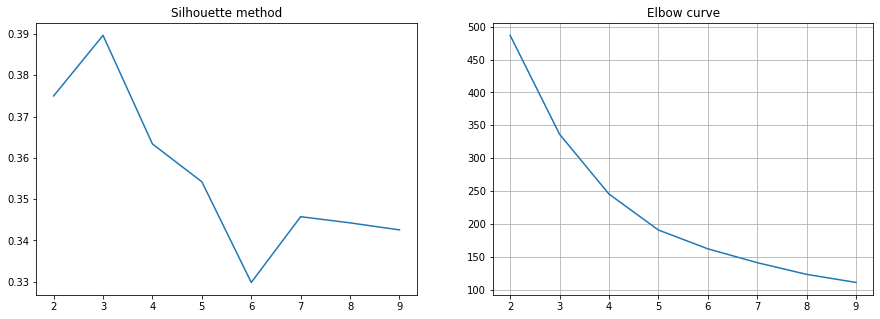

In [232]:
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

RANDOM_STATE=42


# X = loan_train_df
X = loan_train_df[["sex", "age", "region_woe", "balance_mean","balance_min"]]
y = loan_train_df["status"]

X = StandardScaler().fit_transform(X)
X = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X)


distorsions = []
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
    silhouette.append(metrics.silhouette_score(X, kmeans.labels_))


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(2, 10), silhouette)
ax[1].plot(range(2, 10), distorsions)
plt.grid(True)
ax[0].set_title('Silhouette method')
ax[1].set_title('Elbow curve')
plt.show()


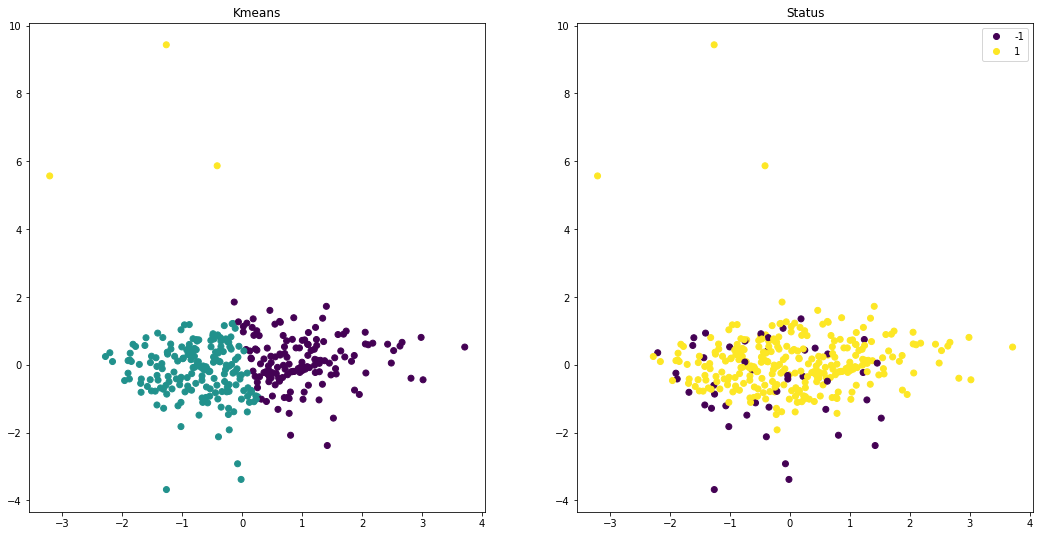

In [253]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# X = loan_train_df
X = loan_train_df[["sex", "age", "region_woe", "balance_mean", "balance_min"]]
y = loan_train_df["status"]

X = StandardScaler().fit_transform(X)
X = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X)
db = KMeans(n_clusters=3, random_state=RANDOM_STATE).fit_predict(X)


# Plot result
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
axs[0].scatter(X[:, 0], X[:, 1], c=db)
scatter = axs[1].scatter(X[:, 0], X[:, 1], c=y)
axs[0].set_title("Kmeans")
axs[1].set_title("Status")

axs[1].legend(handles=scatter.legend_elements()[0], labels=[-1, 1])


### Age

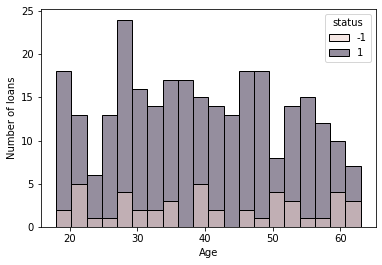

In [211]:
plt.title("Age distribution by loan request")
plt.xlabel("Age")
plt.ylabel("Number of loans")

sb.histplot(data=loan_train_df, x="age", hue="status", bins=20).set(title="");

### Loan amount

<AxesSubplot:xlabel='loan_amount', ylabel='Count'>

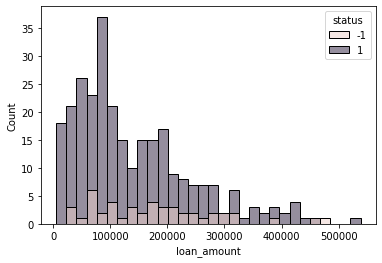

In [212]:
sb.histplot(data=loan_train_df, x=loan_train_df["loan_amount"], hue="status", bins=30)

### Salary


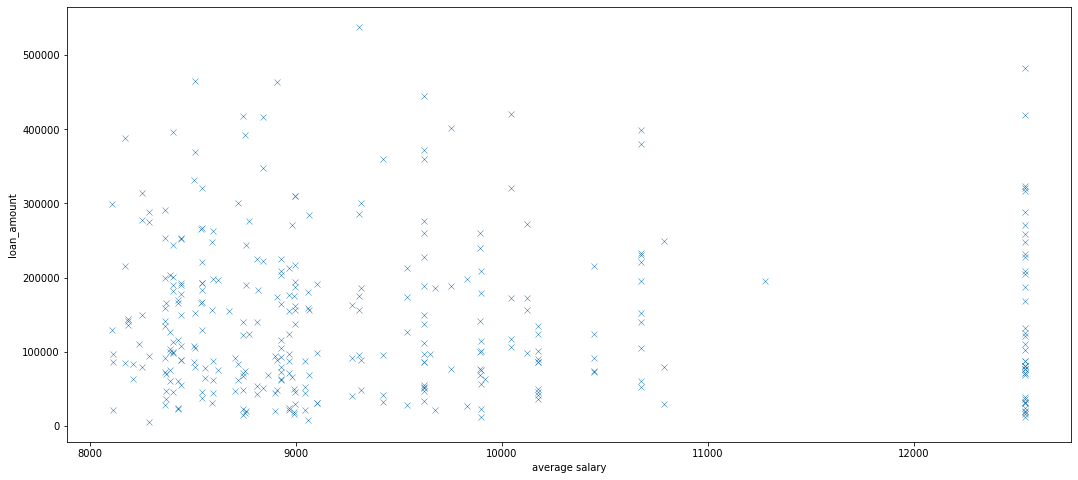

In [213]:
plt.figure(figsize=(18, 8))

sb.scatterplot(x=loan_train_df["average salary"], y=loan_train_df["loan_amount"], marker="x");

### Correlation matrix

C:\Users\Ricardo\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


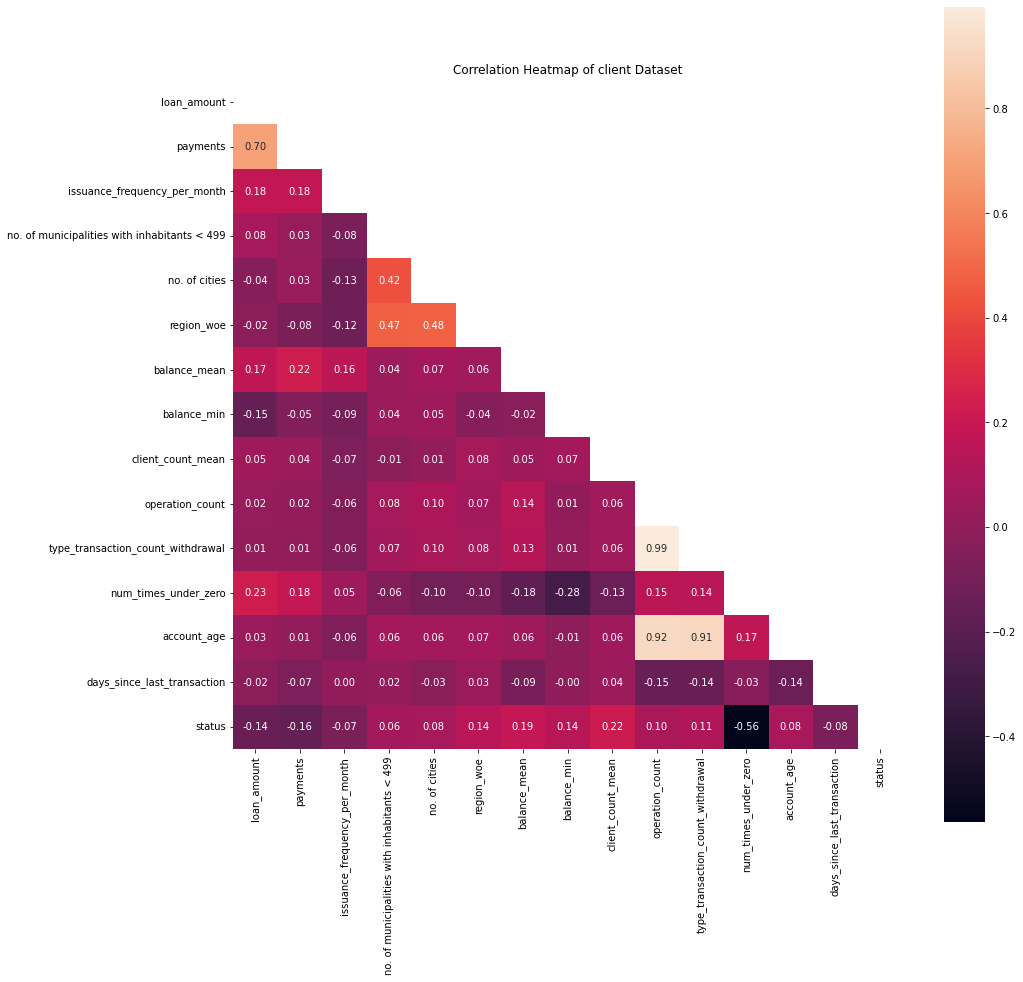

In [214]:
corr_matrix = loan_train_df.drop("loan_id", axis=1).corr(method='spearman')

threshold = 0.05

correlation_status = corr_matrix.loc[['status'], :]
selected_cols = set(correlation_status.loc[:, (abs(correlation_status) > threshold).any()].columns.to_list())
dropped_cols = set.difference(set(correlation_status.columns.to_list()), selected_cols)

loan_train_df.drop(dropped_cols, axis=1, inplace=True)
loan_test_df.drop(dropped_cols, axis=1, inplace=True)

corr_matrix = loan_train_df.drop("loan_id", axis=1).corr(method='spearman')

mask = np.zeros(corr_matrix.shape, dtype=bool)

plt.figure(figsize=(15, 15))

mask[np.triu_indices(len(mask))] = True

plt.title('Correlation Heatmap of client Dataset')

sb.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black', mask=mask)

plt.show()

## Export preprocessed dataframes

In [215]:
loan_train_df.to_pickle("../out/train.pkl")
loan_test_df.to_pickle("../out/test.pkl")